In [39]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import dask
import dask.distributed
#import ncar_jobqueue

import matplotlib.pyplot as plt
from collections import OrderedDict

from itertools import product
from functools import partial

import obm

Consider amplitude of thermal and biological forcing

In [40]:
model = obm.onebox.surface_mixed_layer()

In [41]:
ncp_harmonic = partial(obm.forcing_tools.harmonic, mu=0., phase=-0.5, N=365, steps_per_period=365)
sst_harmonic = partial(obm.forcing_tools.harmonic, mu=7., phase=-0.5, N=365, steps_per_period=365)


In [42]:
#cluster = ncar_jobqueue.NCARCluster()
#client = dask.distributed.Client(cluster)
#n_workers = 9 * 3
#cluster.scale(n_workers)

In [43]:
#client

In [44]:
%%time
do_dask = True

results = []
case = []
thermal_forcing = []
biological_forcing = []

clobber = False

model = {}
state_init = [2033., 308.]
for therm, bio in product(np.arange(0, 10, 1), np.arange(0, 10, 1)):
    casename = f'orcas.gasex-t{therm:03d}-b{bio:03d}'
    case.append(casename)
    thermal_forcing.append(therm)
    biological_forcing.append(bio)
    
    init_file = f'{casename}.npy'
    init_option = 'fsolve'
    
    if os.path.exists(init_file) and not clobber:
        init_option = 'file'
    
    model[casename] = obm.onebox.surface_mixed_layer()
    
    if do_dask:
        model_run = dask.delayed(model[casename].run)
    else:
        model_run = model[casename].run

    forcing_func = lambda therm, bio: model[casename].init_forcing(nday=365., dt=1., 
                                                                   NCP=ncp_harmonic(amp=bio), 
                                                                   TEMP=sst_harmonic(amp=therm))    
        
    out = model_run(time_stop=365., 
                    forcing=forcing_func(therm, bio),
                    init_option=init_option,
                    init_file=init_file,
                    state_init=state_init)
    
    results.append(out)

if do_dask:
    results = dask.compute(*results)
    
case = xr.DataArray(case, dims=('case'), name='case')
ds = xr.concat(results, dim=case)
ds['thermal_forcing'] = xr.DataArray(thermal_forcing, dims=('case'))
ds['biological_forcing'] = xr.DataArray(biological_forcing, dims=('case'))

CPU times: user 8min 40s, sys: 32.5 s, total: 9min 13s
Wall time: 8min 29s


In [45]:
#cluster.close()
#client.close()

Text(0, 0.5, 'Temperature [°C]')

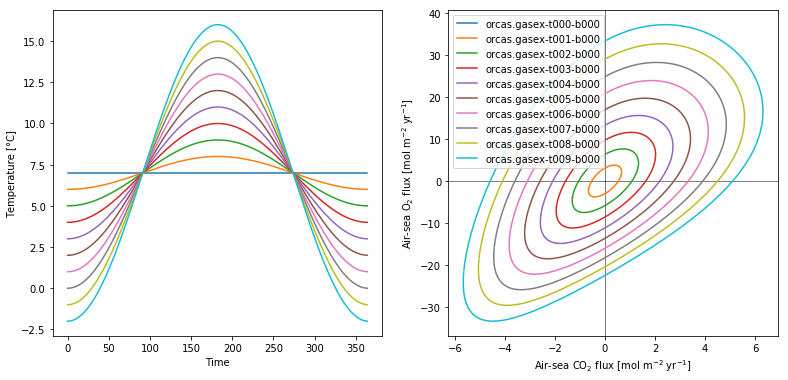

In [46]:
label = lambda da: f"{da.attrs['long_name']} [{da.attrs['units']}]"

xvar = 'stf_CO2'
yvar = 'stf_O2'
caselist = ds.case.loc[ds.biological_forcing==0]


fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 2)
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(-dsc[xvar], -dsc[yvar], label=case.values)
    
ax.axvline(0., color='k', linewidth=0.5, zorder=-10)
ax.axhline(0., color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel(label(ds[xvar]))
ax.set_ylabel(label(ds[yvar]))
plt.legend()

ax = fig.add_subplot(1, 2, 1)    
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(dsc.TEMP, label=case.values)    

ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
    

Text(0, 0.5, 'NCP [mol/m^2/yr]')

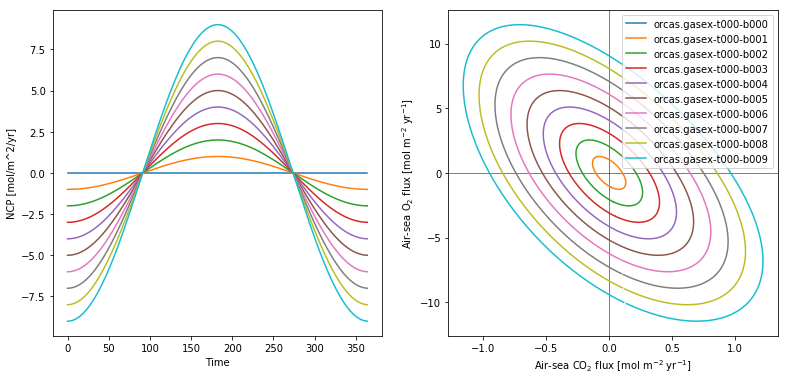

In [47]:
xvar = 'stf_CO2'
yvar = 'stf_O2'

caselist = ds.case.loc[ds.thermal_forcing==0]

fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 2)
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(-dsc[xvar], -dsc[yvar], label=case.values)
    
ax.axvline(0., color='k', linewidth=0.5, zorder=-10)
ax.axhline(0., color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel(label(ds[xvar]))
ax.set_ylabel(label(ds[yvar]))
plt.legend()

ax = fig.add_subplot(1, 2, 1)    
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(dsc.NCP, label=case.values)    

ax.set_xlabel('Time')
ax.set_ylabel(label(ds.NCP))
    

Text(0, 0.5, 'Temperature [deg C]')

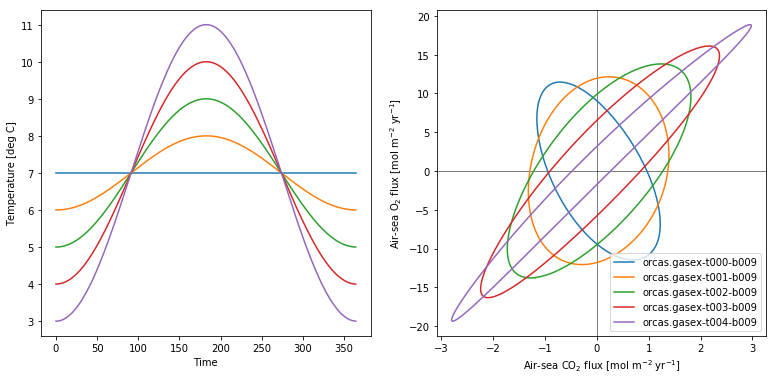

In [48]:
xvar = 'stf_CO2'
yvar = 'stf_O2'

caselist = [f'orcas.gasex-t{i:03d}-b009' for i in range(0, 5)]

fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 2)
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(-dsc[xvar], -dsc[yvar], label=case)
    
ax.axvline(0., color='k', linewidth=0.5, zorder=-10)
ax.axhline(0., color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel(label(ds[xvar]))
ax.set_ylabel(label(ds[yvar]))
plt.legend()

ax = fig.add_subplot(1, 2, 1)    
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(dsc.TEMP, label=case)    

ax.set_xlabel('Time')
ax.set_ylabel(label(ds.TEMP))
    

In [49]:
# size of the boxes [Pg dry air]


In [50]:
out.O2.values[-1]

Delayed('getitem-7020343ae352bc292de5e9c9bc4e9972')

In [51]:
out.NCP.plot()

Delayed('plot-3c431846-5e20-4950-a370-45411717fefc')

In [52]:
import obm
x = obm.atmosphere.o2co2()

In [53]:
x.psi(0)

array([[0. , 0.2, 0. , 0.6],
       [0.2, 0. , 0.4, 0.8],
       [0. , 0.4, 0. , 1. ]])

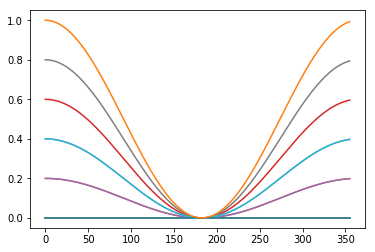

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

for i in range(3):
    for j in range(4):
        plt.plot([x.psi(t)[i, j] for t in np.arange(0, 356, 1)])

In [136]:

mass_air = np.array([5, 20, 15])
tau_exchange = partial(obm.forcing_tools.harmonic, phase=-0.5, N=365, steps_per_period=365)

cyclic = lambda t: t - 365. * np.floor(t / 365.)

time = np.arange(0, 365., 1)
k01 = lambda t: np.interp(cyclic(t), time, tau_exchange(mu=0.1, amp=-0.1))
k12 = lambda t: np.interp(cyclic(t), time, tau_exchange(mu=0.5, amp=-0.5))

k03 = lambda t: np.interp(cyclic(t), time, tau_exchange(mu=0.1, amp=-0.1))
k13 = lambda t: np.interp(cyclic(t), time, tau_exchange(mu=0.5, amp=-0.5))
k23 = lambda t: np.interp(cyclic(t), time, tau_exchange(mu=0.5, amp=-0.5))

M3 = 5

dM = lambda M_t: np.hstack((np.vstack((M_t - M_t[0], M_t - M_t[1], M_t - M_t[2])), (M3 - M_t)[:, None]))

PSI = lambda t: np.array([[0., k01(t), 0., k03(t)], 
                          [k01(t), 0., k12(t), k13(t)], 
                          [0., k12(t), 0., k23(t)]])

stf_CO2 = ds.stf_CO2.loc[(ds.thermal_forcing==0) & (ds.biological_forcing==4)]
stf_O2 = ds.stf_O2.loc[(ds.thermal_forcing==0) & (ds.biological_forcing==4)]

Fco2 = lambda t: np.array([np.interp(cyclic(t), time, (-1.0) * np.squeeze(stf_CO2.values)), 0., 0.])
Fo2 = lambda t: np.array([np.interp(cyclic(t), time, (-1.0) * np.squeeze(stf_O2.values)), 0., 0.])

M_0 = np.ones(6)

dMdt = lambda t, M_t: np.append((Fco2(t) + np.sum(PSI(t) * dM(M_t[0:3]), axis=1)), Fo2(t) + np.sum(PSI(t) * dM(M_t[3:6]), axis=1)) / np.append(mass_air, mass_air)
dMdt(0, M_0)



array([ 0.17369995,  0.2       ,  0.26666667, -0.73804249,  0.2       ,
        0.26666667])

CPU times: user 225 ms, sys: 9.43 ms, total: 234 ms
Wall time: 227 ms


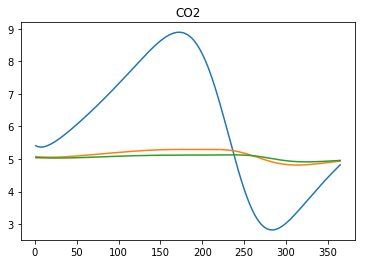

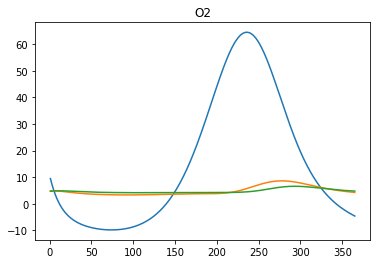

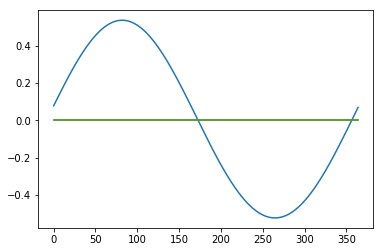

In [171]:
%%time
from scipy.integrate import ode

tf = 365*10

def run_model(tf, state_init):
    dt = 1
    nt = np.int(tf/dt)
    
    soln_time = np.empty(nt)
    soln_state = np.empty((nt, 6))

    solver = ode(dMdt)
    solver.set_integrator('vode')
    solver.set_initial_value(state_init, 0)

    l = 0 
    while solver.successful() and solver.t < tf:
        solver.integrate(solver.t + dt)
        soln_time[l] = solver.t
        soln_state[l, :] = solver.y
        l += 1
    return soln_time, soln_state

soln_time, soln_state = run_model(365, np.array([5.4229273 ,5.07900612, 5.04045131, 10.80588392, 4.7668231, 4.71924047]))

plt.figure()
plt.plot(soln_time, soln_state[:, 0:3])    
plt.title('CO2')

plt.figure()
plt.plot(soln_time, soln_state[:, 3:6])    
plt.title('O2')

plt.figure()
plt.plot([Fco2(t) for t in soln_time])



In [274]:
%%time
import importlib
importlib.reload(obm.atmosphere)
model = obm.atmosphere.o2co2(surface_flux={'CO2': {'BL': (-1.0) * np.squeeze(stf_CO2.values)},
                                           'O2': {'BL': (-1.0) * np.squeeze(stf_O2.values)}})

out = model.run(365*10,  state_init=np.array([5.4229273 ,5.07900612, 5.04045131, 10.80588392, 4.7668231, 4.71924047]))



CPU times: user 49 s, sys: 6.67 s, total: 55.7 s
Wall time: 16.5 s


In [ ]:
for v in ['CO2', 'O2']:
    plt.figure()
    for i in range(len(out.box)):
        out[v].isel(box=i).plot(label=out.box.values[i])
    plt.title(v)
    plt.legend()


plt.figure()
plt.plot([model.Fsrf[0](t) for t in soln_time])

In [249]:
out.CO2.plot()

TypeError: Plotting requires coordinates to be numeric or dates of type np.datetime64, datetime.datetime, cftime.datetime or pd.Interval.

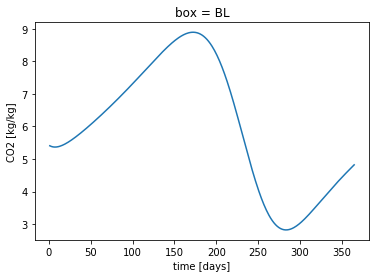

In [252]:
out.CO2.sel(box='BL').plot()